# Deployment to Detect on an Image

##Importing Basic Libraries

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
# import ffmpeg
import os

##Github to OpenPose

In [2]:
# !git clone https://github.com/quanhua92/human-pose-estimation-opencv.git

Cloning into 'human-pose-estimation-opencv'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), done.


##Loading the Trained Weights
The above git file has a file named graph_opt.pb which contains the trained tensorflow weights

In [2]:
net = cv.dnn.readNetFromTensorflow('human-pose-estimation-opencv-master/graph_opt.pb')

##Dimensioning and Defining Body Parts
Going through the openpose.py file, we can see:

parser = argparse.ArgumentParser()

parser.add_argument('--input', help='Path to image or video. Skip to capture frames from camera')

parser.add_argument('--thr', default=0.2, type=float, help='Threshold value for pose parts heat map')

parser.add_argument('--width', default=368, type=int, help='Resize input to specific width.')

parser.add_argument('--height', default=368, type=int, help='Resize input to specific height.')

In [3]:
im_height = 368
im_width = 368
thr = 0.2

In [4]:
BODY_PARTS = BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

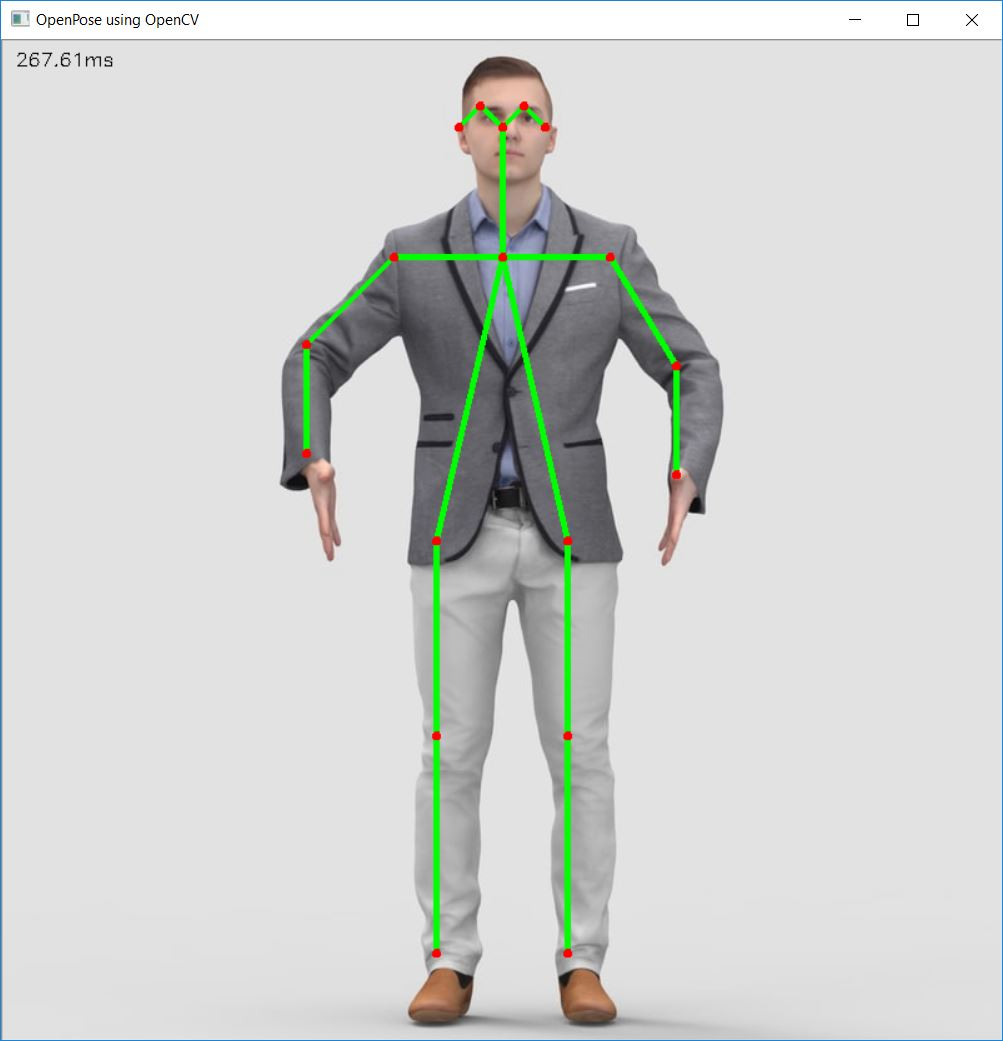

##Function for Detection

In [44]:
# imgfile = str(input('Enter the link to the image'))
img = cv.imread('human-pose-estimation-opencv-master/image.jpg')

Enter the link to the imageC:/Users/Shadow/Downloads/sitting.jpg


As per the Author:

Basically, we need to change the cv.dnn.blobFromImage and use out = out[:, :19, :, :] to get only the first 19 rows in the out variable.

In [45]:
len(BODY_PARTS)#including background

19

In [46]:
def pose_estimation(frame):
  framewidth = frame.shape[1]
  frameheight = frame.shape[0]

  net.setInput(cv.dnn.blobFromImage(frame,1.0,(im_width,im_height),(127.5,127.5,127.5,127.5),swapRB = True,crop = False))
  #swapRB converts the BGR Image to RGB Image
  out = net.forward()
  out = out[:,:19,:,:]#since mobile net is the architecture used and the output returned by it is [1,57,-1,-1]
  assert(len(BODY_PARTS)==out.shape[1])#raises an assertion error if found

  #Defining the various points or location of body parts
  points = []
  for i in range(len(BODY_PARTS)):
    #Heatmap of corresponding body part
    heatmap = out[0,i,:,:]

    #Lets try finding the local maxima and minima points which tells us which body part is it and then apply thresholding
    _,conf,_,point = cv.minMaxLoc(heatmap)

    x = (framewidth*point[0])/out.shape[3]
    y = (frameheight*point[1])/out.shape[2]

    #Add that point if the confidence is higher than the threshold set
    points.append((int(x),int(y)) if conf>thr else None)

  #Mapping the points on the image
  for pair in POSE_PAIRS:
    partfrom = pair[0]
    partto = pair[1]

    assert (partfrom in BODY_PARTS)
    assert (partto in BODY_PARTS)

    idfrom = BODY_PARTS[partfrom]
    idto = BODY_PARTS[partto]

    if points[idfrom] and points[idto]:
      cv.line(frame,points[idfrom],points[idto],(0,255,255),2)
      cv.ellipse(frame,points[idfrom],(3,3),0,0,360,(0,0,255),cv.FILLED)
      cv.ellipse(frame,points[idto],(3,3),0,0,360,(0,0,255),cv.FILLED)

  t,_ = net.getPerfProfile()#This is a performance measuring criteria
  freq = cv.getTickFrequency()/1000
  #The cv.getTickFrequency function returns the frequency of clock-cycles, or the number of clock-cycles per second.

  cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
  return frame



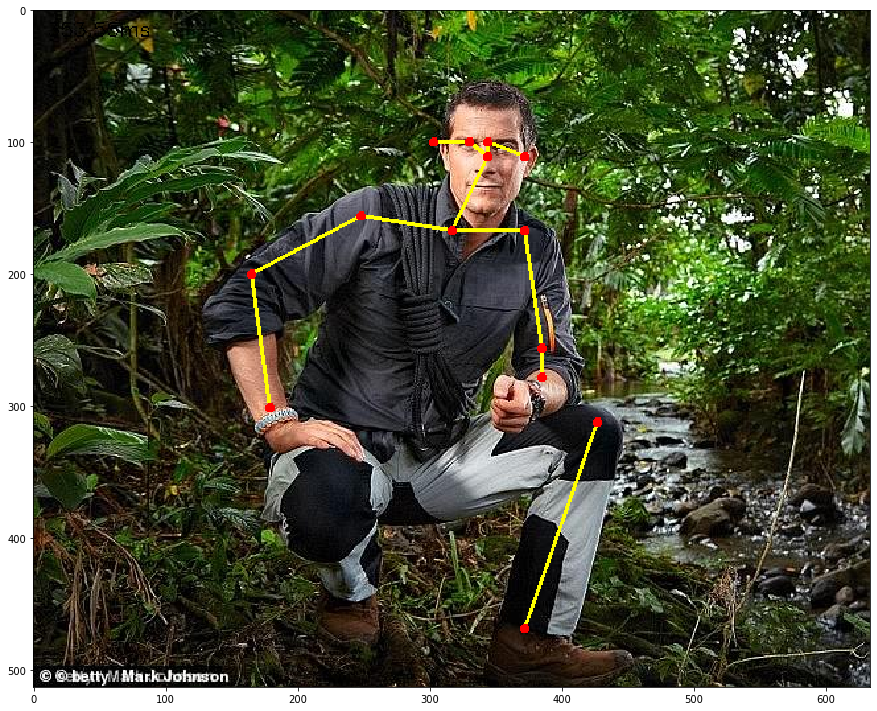

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(pose_estimation(img),cv.COLOR_BGR2RGB))

Limitations:
Can detect if the person is standing straight

In [30]:
val = pose_estimation(img)
val.shape

(513, 634, 3)

In [31]:
img.shape

(513, 634, 3)

# Deployment to Detect on a Video

In [39]:
# videofile = input('Enter the link to the videofile')
cap = cv.VideoCapture('human-pose-estimation-opencv-master/jog.mp4')
cap.set(3,800)#Setting the height
cap.set(4,800)#setting the width
cap.isOpened()

Enter the link to the videofileE:\\EDUREKA CLASSROOM\\Fantastic Codes\\Human Pose\\human-pose-estimation-opencv-master\\jog.mp4


True

In [40]:
if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError('Cannot Open Video')

In [41]:
type(cap)

cv2.VideoCapture

In [42]:
while cv.waitKey(1)<0:
    hasframe,frame = cap.read()
    if not hasframe:
        cv.waitKey()
        break
        
    framewidth = frame.shape[1]
    frameheight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame,1,(im_width,im_height),(127.5,127.5,127.5),swapRB = True,crop = False))
    out = net.forward()
    
    out = out[:,:19,:,:]
    assert(len(BODY_PARTS)==out.shape[1])
    points = []
    
    for i in range(len(BODY_PARTS)):
        #slice heatmap of corresponding body part
        heatmap = out[0,i,:,:]
        
        #Finding Global Maxima
        
        _,conf,_,point = cv.minMaxLoc(heatmap)
        x = (framewidth*point[0])/out.shape[3]
        y = (frameheight*point[1])/out.shape[2]
        
        points.append((int(x),int(y)) if conf>thr else None)
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
            
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
            
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
            
        if points[idFrom] and points[idTo]:
            cv.line(frame,points[idFrom],points[idTo],(0,255,0),2)
            cv.ellipse(frame,points[idFrom],(3,3),0,0,360,(0,0,255))#here (3,3) denotes the major and minor axes length of the ellipse
            cv.ellipse(frame,points[idTo],(3,3),0,0,360,(0,0,255))#here (3,3) denotes the major and minor axes length of the ellipse
            
    #Performance Measuring Criteria
    t,_ = net.getPerfProfile()
    freq = cv.getTickFrequency()/1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))


        
    cv.imshow('Pose',frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()   

'4.5.3'

# Detection Over Webcam

In [36]:
cap = cv.VideoCapture(0)
cap.set(3,800)
cap.set(4,800)

True

In [37]:
while cv.waitKey(1)<0:
    hasframe,frame = cap.read()
    if not hasframe:
        cv.waitKey()
        break
        
    framewidth = frame.shape[1]
    frameheight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame,1,(im_width,im_height),(127.5,127.5,127.5),swapRB = True,crop = False))
    out = net.forward()
    
    out = out[:,:19,:,:]
    assert(len(BODY_PARTS)==out.shape[1])
    points = []
    
    for i in range(len(BODY_PARTS)):
        #slice heatmap of corresponding body part
        heatmap = out[0,i,:,:]
        
        #Finding Global Maxima
        
        _,conf,_,point = cv.minMaxLoc(heatmap)
        x = (framewidth*point[0])/out.shape[3]
        y = (frameheight*point[1])/out.shape[2]
        
        points.append((int(x),int(y)) if conf>thr else None)
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
            
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
            
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
            
        if points[idFrom] and points[idTo]:
            cv.line(frame,points[idFrom],points[idTo],(0,255,0),2)
            cv.ellipse(frame,points[idFrom],(3,3),0,0,360,(0,0,255))#here (3,3) denotes the major and minor axes length of the ellipse
            cv.ellipse(frame,points[idTo],(3,3),0,0,360,(0,0,255))#here (3,3) denotes the major and minor axes length of the ellipse
            
    #Performance Measuring Criteria
    t,_ = net.getPerfProfile()
    freq = cv.getTickFrequency()/1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))


        
    cv.imshow('Pose',frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()   